## Fine-tuning PaliGemma on the RISCM dataset

In this notebook we will (try to) fine-tune the PaliGemma model with the RISCM satellite imagery dataset for image-captioning. This forms the basis to compare fine-tuning methods. For training with Adapters and QVLA see vision_adapter_paligemma.ipynb and qvla_paligemma.ipynb respectively.

In [1]:
#!pip install -U bitsandbytes
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 22.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [2]:
#Connect to drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/DI725/DI725-project


Mounted at /content/drive
/content/drive/MyDrive/DI725/DI725-project


In [3]:
import torch
from torch import nn

from transformers import BitsAndBytesConfig
from transformers import AutoProcessor, AutoModel, PaliGemmaForConditionalGeneration, AutoConfig

from huggingface_hub import notebook_login

from datasets import load_dataset

import wandb
import time

In [4]:
#defining the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "google/paligemma-3b-pt-224" # pt for pre-trained, needs fine-tuning

### Loading the dataset

See dataset_visualizations.ipynb for a more detailed description of the dataset.

In [7]:
dataset = load_dataset("json", data_files={'train': 'RISCM/resized/train_data.jsonl', 'test':'RISCM/resized/test_data.jsonl', 'validation':"RISCM/resized/val_data.jsonl"})

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [8]:
#We need to log-in before using the PaliGemma model, as it is subject to agreement

notebook_login()

### Loading the model

In [9]:
base_model = PaliGemmaForConditionalGeneration.from_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [10]:
processor = AutoProcessor.from_pretrained(model_id)
config = AutoConfig.from_pretrained(model_id)

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

In [11]:
base_model.to(device)

PaliGemmaForConditionalGeneration(
  (model): PaliGemmaModel(
    (vision_tower): SiglipVisionModel(
      (vision_model): SiglipVisionTransformer(
        (embeddings): SiglipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
          (position_embedding): Embedding(256, 1152)
        )
        (encoder): SiglipEncoder(
          (layers): ModuleList(
            (0-26): 27 x SiglipEncoderLayer(
              (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
              (self_attn): SiglipAttention(
                (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
              )
              (layer_norm2): LayerNorm((1152,), eps=1e-06, elem

## Prepare dataset for training

We need to tokenize the inputs as expected by PaliGemma (https://huggingface.co/blog/paligemma)

In [19]:
image_dir = "RISCM/resized/"
from PIL import Image
import PIL
def collate_fn(examples):
      texts = [f"<image> <bos> {example['prefix']}" for example in examples]
      labels= [example['suffix'] for example in examples]
      images = [PIL.Image.open(image_dir + example["file_name"]).convert("RGB") for example in examples]
      tokens = processor(text=texts, images=images, suffix=labels,
      return_tensors="pt", padding="longest")
      tokens = tokens.to(torch.bfloat16).to(device)
      return tokens

In [ ]:
wandb.init(
    project="paligemma-finetune",
    name="run_base_batch4",
    config={
        "num_train_epochs": 2,
        "per_device_train_batch_size": 4,
        "gradient_accumulation_steps": 1,
        "learning_rate": 5e-4,
        "weight_decay": 1e-6,
        "adam_beta2": 0.999,
        "optim": "paged_adamw_8bit",
        "bf16": True,

    }
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yildizz-nisan (yildizz-nisan-middle-east-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Training

We can use the TrainingArguments and Trainer functions from the transformers library to effortlesly train our model (although we will get a memory error).

In [ ]:
from transformers import TrainingArguments, EarlyStoppingCallback, Trainer
args=TrainingArguments(
            num_train_epochs=1,
            remove_unused_columns=False,
            per_device_train_batch_size=4,
            gradient_accumulation_steps=1,
            warmup_steps=2,
            learning_rate=5e-4,
            weight_decay=1e-6,
            adam_beta2=0.999,
            logging_steps=100,
            optim="paged_adamw_8bit", # you can use paged optimizers like paged_adamw_8bit for Q or adamw_hf
            save_strategy="steps",
            save_steps=1000,
            save_total_limit=1,
            output_dir="paligemma_base",
            bf16=True,
            report_to=["wandb"],
            dataloader_pin_memory=False,
            eval_strategy="steps",
            eval_steps=1000,
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
        )


In [ ]:
trainer = Trainer(
    model=base_model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    data_collator=collate_fn,
    args=args
)

train_start = time.time()
trainer.train()
train_time = time.time() - train_start
print(f"Training time: {train_time:.2f} seconds")

Step,Training Loss,Validation Loss


KeyboardInterrupt: 

## Inference

Although there is a model method to generate captions namely .generate(), it fails to run properly with added adapters. For the sake of consistency, here and with models with adapters, we use a custom generate_caption() function via using model(**input) and to generate tokens and manually decode them.

In [12]:
def generate_caption(model, processor, input_text, input_image):
    inputs = processor(text=input_text,
                       images=input_image,
                       padding="longest",
                       do_convert_rgb=True,
                       return_tensors="pt").to(device)

    input_ids = inputs["input_ids"].to(device)
    pixel_values = inputs["pixel_values"].to(device)
    input_len = input_ids.shape[1]
    generated = input_ids.clone()
    max_new_tokens = 32

    with torch.no_grad():
        past_key_values = None
        for _ in range(max_new_tokens):
            model_inputs = {"input_ids": generated}
            if past_key_values is not None:
                model_inputs["past_key_values"] = past_key_values
            if generated.shape[1] == input_len:  # only pass pixel_values on first step
                model_inputs["pixel_values"] = pixel_values
            out = model(**model_inputs)
            next_token = out.logits[:, -1, :].argmax(dim=-1, keepdim=True)
            generated = torch.cat([generated, next_token], dim=1)
            past_key_values = out.past_key_values
            if next_token.item() == processor.tokenizer.eos_token_id:
                break
        # decode generated tokens (skip input prompt)
        caption_ids = generated[0, input_len:]
        caption = processor.decode(caption_ids, skip_special_tokens=True)
        return caption.strip()


In [ ]:
#installing pycocoevalcap for CIDEr metric
!pip install git+https://github.com/salaniz/pycocoevalcap

  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-sh71p54j
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-sh71p54j
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=380f3103e1ab08c5734641982e399922d68c07b860334dd7101abf54cbc8f2e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-6r46umt8/wheels/d2/1f/44/6485e566f8ae3d42b56e7c05fd50a3bbb70a50b0e6e7c55212
Successfully built pycocoevalcap


In [ ]:
from pycocoevalcap.cider.cider import Cider
from tqdm import tqdm

In [16]:
image_dir = "RISCM/resized/"

In [ ]:
gts = {}  # ground truths
res = {}  # results


base_model.eval()

eval_start = time.time()
for idx, example in tqdm(enumerate(dataset['test']), "inference on test test"):
    input_image = PIL.Image.open(image_dir + example["file_name"])
    references = [example['suffix']]  # list of reference captions
    input_text = f"<image> <bos> {example['prefix']}"

    pred_caption = generate_caption(model = base_model,
                                    processor = processor,
                                    input_text = input_text,
                                    input_image = input_image)
    gts[idx] = references
    res[idx] = [pred_caption]

eval_time = time.time() - eval_start
print(f"Evaluation time: {eval_time:.2f} seconds")

# Calculate CIDEr
cider_scorer = Cider()
score, scores = cider_scorer.compute_score(gts, res)
print(f"CIDEr score: {score:.4f}")

inference on test test: 4454it [2:30:46,  2.03s/it]


Evaluation time: 9046.92 seconds
CIDEr score: 0.0006


## Example captions

In [20]:
example_ids = [42, 132, 1024, 2062, 4000]
example_gt = []
example_pred = []

for example_id in example_ids:
    example = dataset['test'][example_id]
    input_image = PIL.Image.open(image_dir + example["file_name"])
    references = [example['suffix']]  # list of reference captions
    input_text = f"<image> <bos> {example['prefix']}"

    pred_caption = generate_caption(model = base_model,
                                    processor = processor,
                                    input_text = input_text,
                                    input_image = input_image)
    example_gt.append(references)
    example_pred.append([pred_caption])

### Predicted captions

In [27]:
!mkdir example_captions
!mkdir example_captions/base_paligemma
!mkdir example_captions/gt_captions

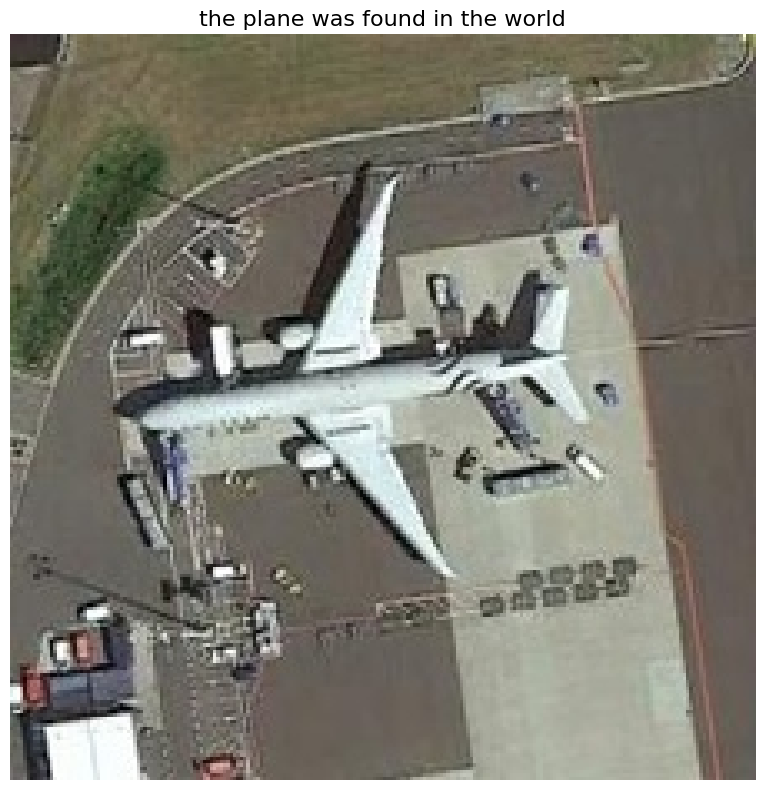

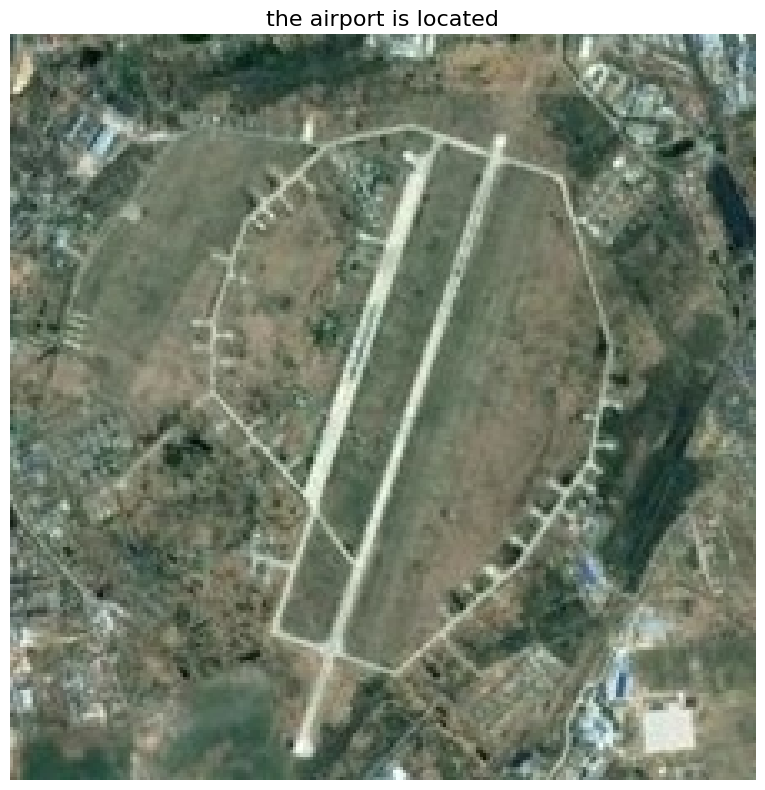

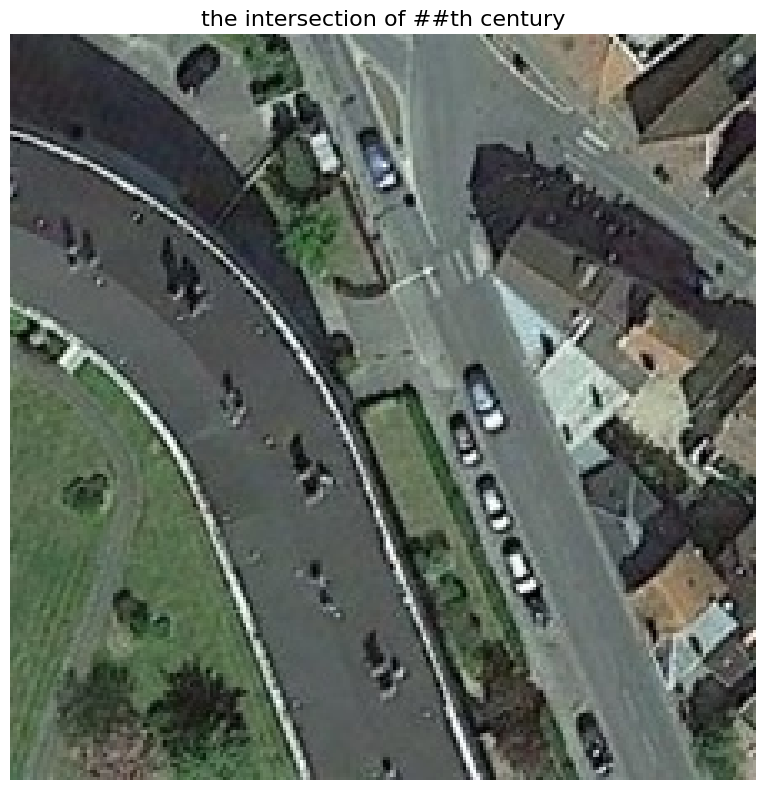

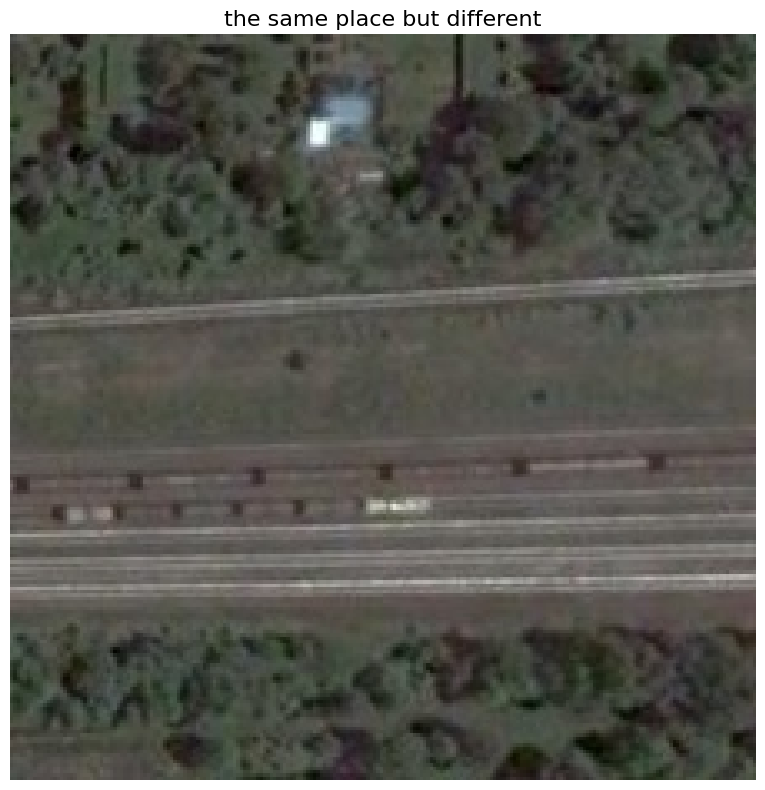

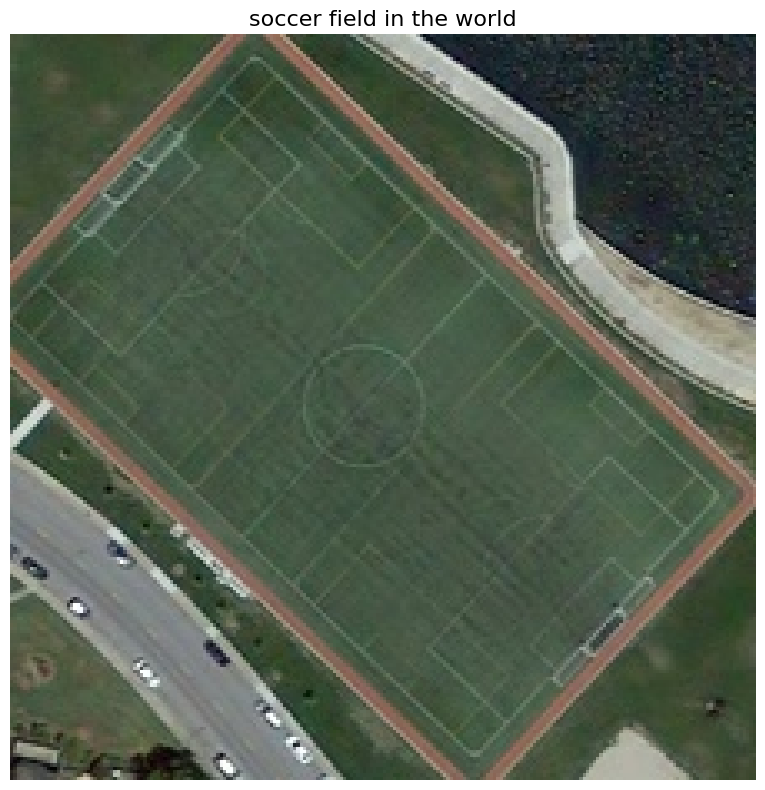

In [31]:
import matplotlib.pyplot as plt
for i in range(len(example_ids)):
    img = PIL.Image.open(image_dir + dataset['test'][example_ids[i]]["file_name"])
    caption = example_pred[i][0]
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16)
    plt.tight_layout()
    plt.savefig(f"example_captions/base_paligemma/test_{example_ids[i]}.png")
    plt.show()

### Ground truth captions

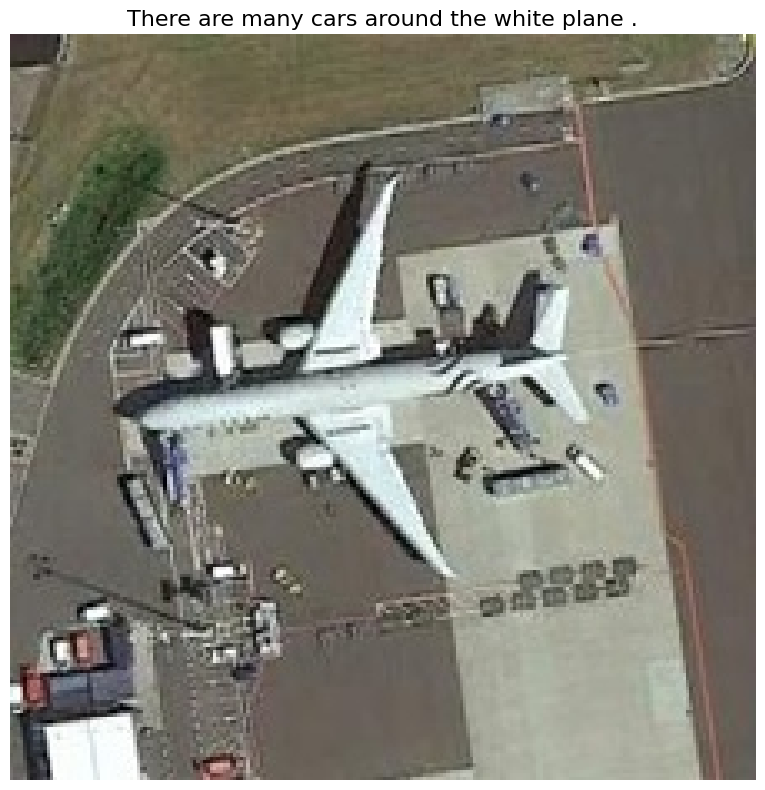

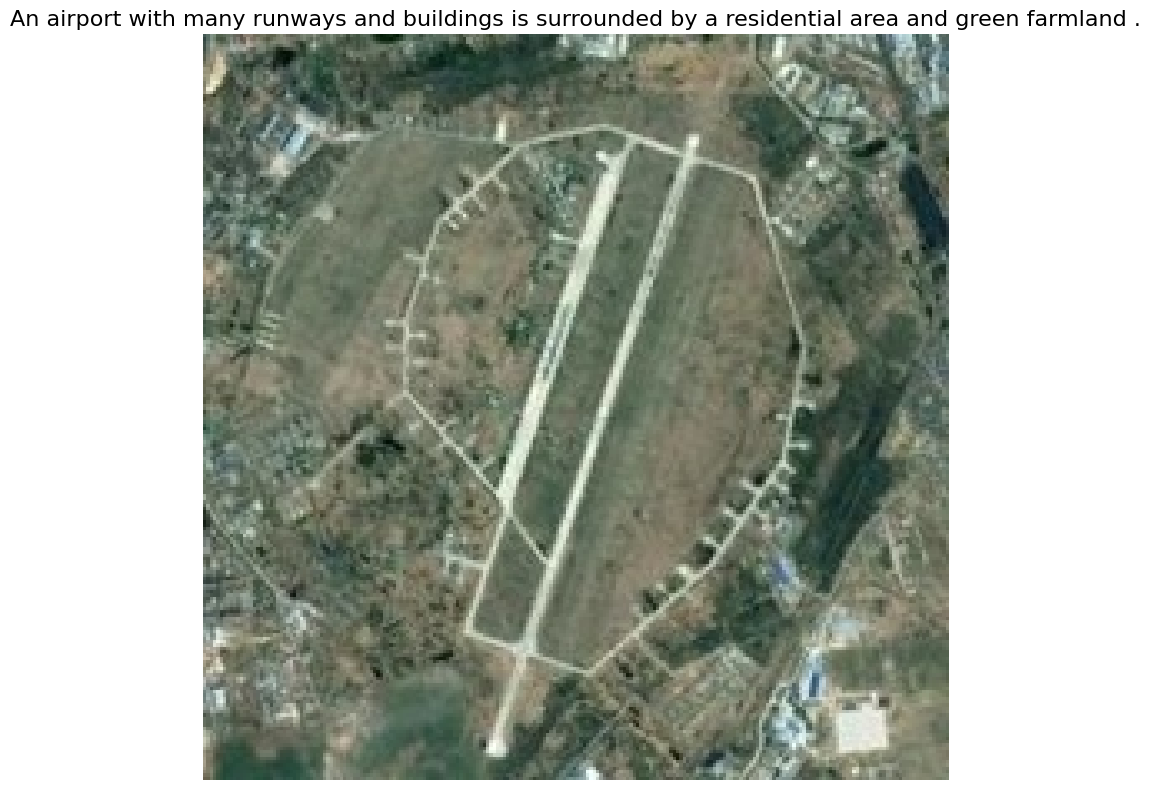

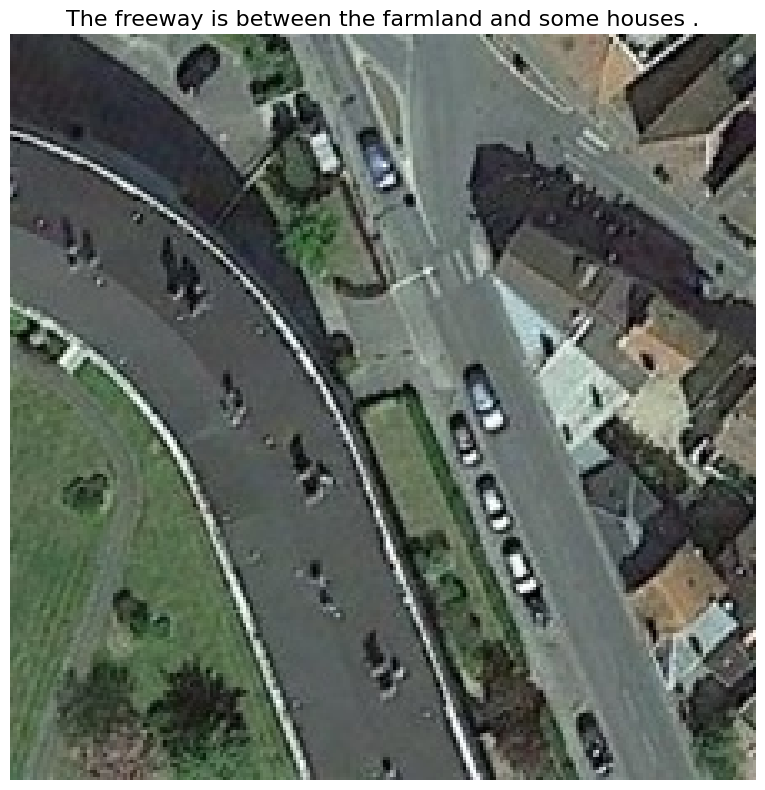

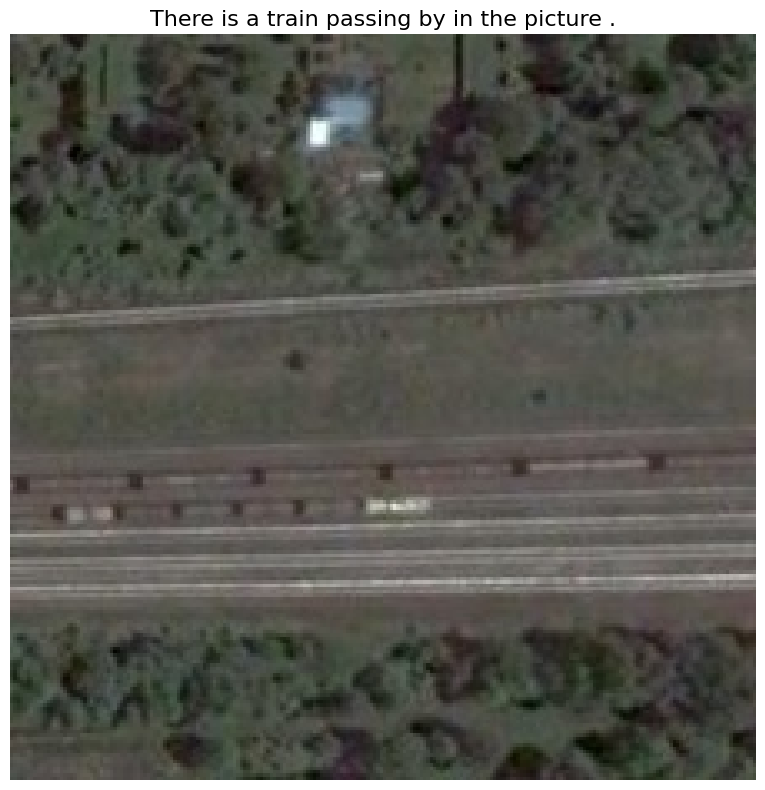

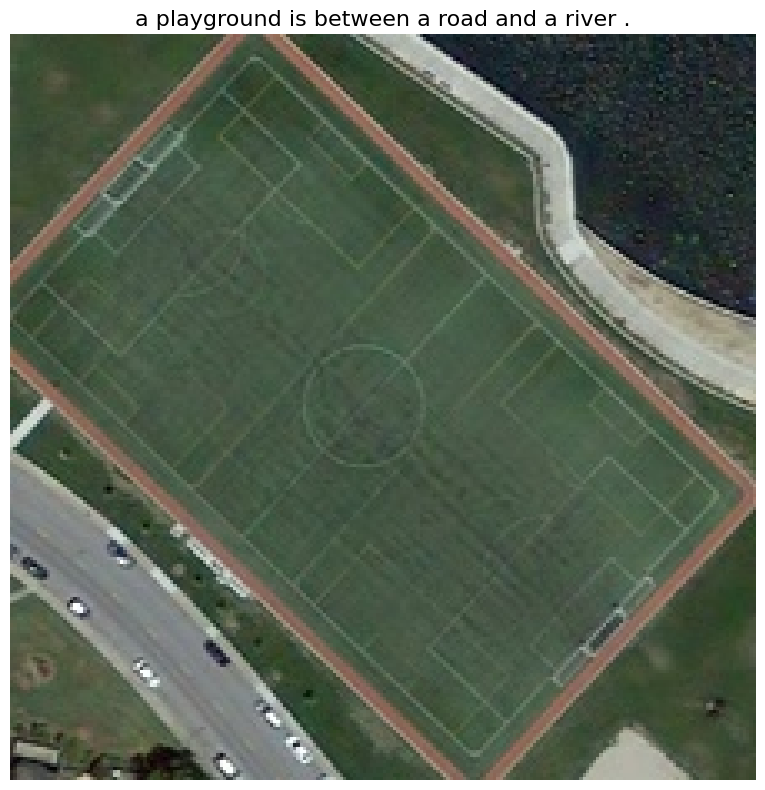

In [32]:
import matplotlib.pyplot as plt
for i in range(len(example_ids)):
    img = PIL.Image.open(image_dir + dataset['test'][example_ids[i]]["file_name"])
    caption = example_gt[i][0]
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16)
    plt.tight_layout()
    plt.savefig(f"example_captions/gt_captions/test_{example_ids[i]}.png")
    plt.show()

